##### Copyright 2025 Google LLC.

In [39]:
#@title Licensed under the Apache License, Version 2.0 (the "License");
# you may not use this file except in compliance with the License.
# You may obtain a copy of the License at
#
# https://www.apache.org/licenses/LICENSE-2.0
#
# Unless required by applicable law or agreed to in writing, software
# distributed under the License is distributed on an "AS IS" BASIS,
# WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
# See the License for the specific language governing permissions and
# limitations under the License.

## Gemini 2.0 - Grounding using Search as a tool

<a target="_blank" href="https://colab.research.google.com/github/google-gemini/cookbook/blob/main/quickstarts/Search_Grounding.ipynb"><img src="https://colab.research.google.com/assets/colab-badge.svg" height=30/></a>

In this notebook you will learn how to use the new Google Search tool available in [Gemini 2.0](https://ai.google.dev/gemini-api/docs/models/gemini-v2), using both the unary API and the Multimodal Live API. Check out the docs to learn more about using [Search as a tool](https://ai.google.dev/gemini-api/docs/models/gemini-v2#search-tool).

Note that the previous version of this guide using Gemini models priori to 2.0 and the legacy SDK can still be found [here](https://github.com/google-gemini/cookbook/blob/gemini-1.5-archive/quickstarts/Search_Grounding.ipynb).

## Set up the SDK

This guide uses the [`google-genai`](https://pypi.org/project/google-genai) Python SDK to connect to the Gemini 2.0 models.

### Install SDK

The new **[Google Gen AI SDK](https://github.com/googleapis/python-genai)** provides programmatic access to Gemini 2 (and previous models) using both the [Google AI for Developers](https://ai.google.dev/gemini-api/docs/models/gemini-v2) and [Vertex AI](https://cloud.google.com/vertex-ai/generative-ai/docs/overview) APIs. With a few exceptions, code that runs on one platform will run on both. This means that you can prototype an application using the Developer API and then migrate the application to Vertex AI without rewriting your code.

More details about this new SDK on the [documentation](https://googleapis.github.io/python-genai/) or in the [Getting started](./Get_started.ipynb) notebook.

In [40]:
%pip install -q -U "google-genai>=1.0.0"

### Set up your API key

To run the following cell, your API key must be stored it in a Colab Secret named `GOOGLE_API_KEY`. If you don't already have an API key, or you're not sure how to create a Colab Secret, see the [Authentication](https://github.com/google-gemini/gemini-api-cookbook/blob/main/quickstarts/Authentication.ipynb) quickstart for an example.

In [41]:
import os
from google.colab import userdata

os.environ['GOOGLE_API_KEY'] = userdata.get('GOOGLE_API_KEY')

### Select model and initialize SDK client

The client will pick up your API key from the environment variable.
To use the live API you need to set the client version to `v1alpha` and use the Gemini 2.0 model.

Now select the model you want to use in this guide, either by selecting one in the list or writing it down. Keep in mind that some models, like the 2.5 ones are thinking models and thus take slightly more time to respond (cf. [thinking notebook](./Get_started_thinking.ipynb) for more details and in particular learn how to switch the thiking off).

In [42]:
from google import genai

client = genai.Client() # the API is automatically loaded from the environement variable

MODEL_ID = "gemini-2.5-pro-preview-05-06" # @param ["gemini-2.0-flash-lite","gemini-2.0-flash","gemini-2.5-flash","gemini-2.5-pro-preview-05-06"] {"allow-input":true, isTemplate: true}

## Use Google Search
Search grounding is particularly useful for queries that require current information or external knowledge. Using Google Search, Gemini can access nearly real-time information and better responses.

In [43]:
from IPython.display import HTML, Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents='What was the latest Indian Premier League match and who won?',
    config={"tools": [{"google_search": {}}]},
)

# print the response
display(Markdown(f"Response:\n {response.text}"))
# print the search details
print(f"Search Query: {response.candidates[0].grounding_metadata.web_search_queries}")
# urls used for grounding
print(f"Search Pages: {', '.join([site.web.title for site in response.candidates[0].grounding_metadata.grounding_chunks])}")

display(HTML(response.candidates[0].grounding_metadata.search_entry_point.rendered_content))

Response:
 The latest Indian Premier League (IPL) match was the **IPL 2024 Final**, played on May 26, 2024, at the M. A. Chidambaram Stadium in Chennai.

**Kolkata Knight Riders (KKR) won their third IPL title by defeating Sunrisers Hyderabad (SRH) by 8 wickets**.

Sunrisers Hyderabad chose to bat first after winning the toss but were bowled out for 113 runs, the lowest total ever in an IPL final. Kolkata Knight Riders chased down the target of 114 runs in just 10.3 overs, with 57 balls to spare.

Venkatesh Iyer of KKR was a key performer in the chase, scoring an unbeaten 52 runs off 26 balls. Mitchell Starc from KKR was named the Player of the Match. Sunil Narine, also from KKR, was named the Player of the Season.

Search Query: ['latest Indian Premier League match result', 'IPL 2024 final match result']
Search Pages: business-standard.com, wikipedia.org, bbc.co.uk, aljazeera.com, jagranjosh.com


The information provided may be outdated, as it is based on a knowledge cutoff. For the most current and authoritative details, please refer to the official [Model documentation](https://ai.google.dev/gemini-api/docs/models#gemini-2.5-pro-preview-05-06), which includes the latest knowledge cutoff date.

You can see that running the same prompt without search grounding gives you outdated information:

In [44]:
from IPython.display import Markdown

response = client.models.generate_content(
    model=MODEL_ID,
    contents='What was the latest Indian Premier League match and who won?',
)

# print the response
display(Markdown(response.text))

The latest Indian Premier League (IPL) match was the **Final of IPL 2024**, played on **May 26, 2024**.

It was between **Kolkata Knight Riders (KKR)** and **Sunrisers Hyderabad (SRH)**.

**Kolkata Knight Riders (KKR) won** the match comprehensively by 8 wickets to clinch their third IPL title.

## Use search in chat

Start by defining a helper function that you will use to display each part of the returned response.

In [45]:
# @title Define some helpers (run this cell)
import json

from IPython.display import display, HTML, Markdown


def show_json(obj):
  print(json.dumps(obj.model_dump(exclude_none=True), indent=2))

def show_parts(r):
  parts = r.candidates[0].content.parts
  if parts is None:
    finish_reason = r.candidates[0].finish_reason
    print(f'{finish_reason=}')
    return
  for part in r.candidates[0].content.parts:
    if part.text:
      display(Markdown(part.text))
    elif part.executable_code:
      display(Markdown(f'```python\n{part.executable_code.code}\n```'))
    else:
      show_json(part)

  grounding_metadata = r.candidates[0].grounding_metadata
  if grounding_metadata and grounding_metadata.search_entry_point:
    display(HTML(grounding_metadata.search_entry_point.rendered_content))


First try a query that needs realtime information, so you can see how the model performs _without_ Google Search.

In [46]:
chat = client.chats.create(model=MODEL_ID)

response = chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')

show_parts(response)

The most recent prominent game I can find between national teams of **Australia** and **Chinese Taipei** was in **Women's Basketball**.

*   **Australia defeated Chinese Taipei 91-56** in the FIBA Women's Asia Cup on **September 29, 2023.**

If you were thinking of a different sport (like men's soccer, where Australia won 5-1 in a World Cup Qualifier on June 7, 2021), please let me know!

Now set up a new chat session that uses the `google_search` tool.  The `show_parts` helper will display the text output as well as any Google Search queries used in the results.

In [47]:
search_tool = {'google_search': {}}

soccer_chat = client.chats.create(
    model=MODEL_ID,
    config={'tools': [search_tool]}
)

response = soccer_chat.send_message('Who won the most recent Australia vs Chinese Taipei games?')

show_parts(response)

It appears you're asking about recent games between Australia and Chinese Taipei, but it's important to specify which sport as they compete in several. Here's a summary of recent results in Football (Soccer) and Futsal:

**Football (Soccer) - Women's:**

*   Australia's women's national team, the Matildas, have a strong record against Chinese Taipei. In their last three matches, Australia won all three.
*   The most recent of these encounters was on November 1, 2023, as part of the AFC Women's Olympic Qualifying Tournament, where Australia won 3-0.
*   Looking further back, Australia also defeated Chinese Taipei 6-0 in an International Friendly on December 7, 2024.
*   In games played since 2008, Australia Women have won all 6 matches against Chinese Taipei (w).

**Futsal - Women's:**

*   In a recent match in the AFC Women's Futsal Asian Cup 2025™, Chinese Taipei defeated the Australian Women's Futsal Team 1-0. This result meant Australia did not progress to the knockout stages of the tournament.

**Basketball - Men's & Women's:**
While there are records of past basketball games, pinpointing the "most recent" can be tricky without a specific tournament or date.

*  For men's basketball, in the FIBA World Cup Qualification, Asia & Oceania, Australia defeated Chinese Taipei 90-71 on February 28, 2022.
* For women's basketball, Australia has won 3 of their head-to-head matchups.

To get the most accurate information for basketball, you would need to specify if you're interested in men's or women's basketball and potentially the tournament or a more precise timeframe.

As you are using a `chat` session, you can ask the model follow-up questions too.

In [48]:
response = soccer_chat.send_message('Who scored the goals?')

show_parts(response)

Okay, here's who scored in those recent matches:

**Football (Soccer) - Women's Olympic Qualifying (November 1, 2023): Australia 3 - 0 Chinese Taipei**

*   Mary Fowler (Australia) scored in the 62nd minute.
*   Sam Kerr (Australia) scored in the 68th minute.
*   Tameka Yallop (Australia) scored in the 76th minute.

**Futsal - Women's AFC Futsal Asian Cup 2025™ (Recent Match, likely May 9th or 10th, 2025): Chinese Taipei 1 - 0 Australia**

*   Liu Chih-Ling (Chinese Taipei) scored the only goal of the match.

## Plot search results


In this example you can see how to use the Google Search tool with code generation in order to plot results.

In [50]:
movie_chat = client.chats.create(
    model=MODEL_ID,
    config={'tools': [search_tool]}
)

response = movie_chat.send_message('Generate some Python code to plot the runtimes of the 10 more recent Denis Villeneuve movies.')

show_parts(response)

```python
import matplotlib.pyplot as plt

# Data for the 10 most recent Denis Villeneuve movies
# Movie Title, Release Year, Runtime (minutes)
movies_data = [
    ("Dune: Part Two", 2024, 166),  # Runtime for Dune: Part Two is 167 minutes. [8]
    ("Dune: Part One", 2021, 155),  # [10]
    ("Blade Runner 2049", 2017, 163), # IMDb shows 2h 44m -> 164. Some sources say 163.
    ("Arrival", 2016, 116),  # [7]
    ("Sicario", 2015, 121),   # IMDb shows 2h 1m -> 121
    ("Enemy", 2013, 90),     # IMDb shows 1h 30m -> 90
    ("Prisoners", 2013, 153),  # [9]
    ("Incendies", 2010, 131),  # [2]
    ("Polytechnique", 2009, 77),  # [2]
    ("Next Floor", 2008, 11) # Short film, IMDb shows 11m
]

# Sort movies by release year for chronological plotting (already mostly sorted)
movies_data.sort(key=lambda x: x[1])

# Extracting data for plotting
titles = [movie[0] for movie in movies_data]
runtimes = [movie[2] for movie in movies_data]
release_years = [movie[1] for movie in movies_data]

# Create the plot
plt.figure(figsize=(12, 8))
bars = plt.barh(titles, runtimes, color='skyblue')

# Add runtime labels to each bar
for bar in bars:
    plt.text(bar.get_width() + 5,  # Position text slightly to the right of the bar
             bar.get_y() + bar.get_height()/2,
             f'{bar.get_width()} min',
             va='center')

# Add titles and labels
plt.xlabel("Runtime (minutes)")
plt.ylabel("Movie Title")
plt.title("Runtimes of the 10 Most Recent Denis Villeneuve Movies")
plt.gca().invert_yaxis() # To display the most recent movie at the top
plt.tight_layout()

# Show the plot
plt.show()
```



This Python code will generate a horizontal bar chart displaying the runtimes of Denis Villeneuve's 10 most recent films. Each bar will represent a movie, with its length corresponding to the runtime in minutes. The movie titles will be on the y-axis, and the runtimes on the x-axis. The specific runtime and release year for each film has been sourced from the search results. The chart will be titled appropriately, and the axes will be labeled for clarity. The most recent movie will appear at the top of the chart.

First review the supplied code to make sure it does what you expect, then copy it here to try out the chart.

import matplotlib.pyplot as plt

# Data for the 10 most recent Denis Villeneuve movies
# Movie Title, Release Year, Runtime (minutes)
movies_data = [
    ("Dune: Part Two", 2024, 166),  # Runtime for Dune: Part Two is 167 minutes. [8]
    ("Dune: Part One", 2021, 155),  # [10]
    ("Blade Runner 2049", 2017, 163), # IMDb shows 2h 44m -> 164. Some sources say 163.
    ("Arrival", 2016, 116),  # [7]
    ("Sicario", 2015, 121),   # IMDb shows 2h 1m -> 121
    ("Enemy", 2013, 90),     # IMDb shows 1h 30m -> 90
    ("Prisoners", 2013, 153),  # [9]
    ("Incendies", 2010, 131),  # [2]
    ("Polytechnique", 2009, 77),  # [2]
    ("Next Floor", 2008, 11) # Short film, IMDb shows 11m
]

# Sort movies by release year for chronological plotting (already mostly sorted)
movies_data.sort(key=lambda x: x[1])

# Extracting data for plotting
titles = [movie[0] for movie in movies_data]
runtimes = [movie[2] for movie in movies_data]
release_years = [movie[1] for movie in movies_data]

# Create the plot


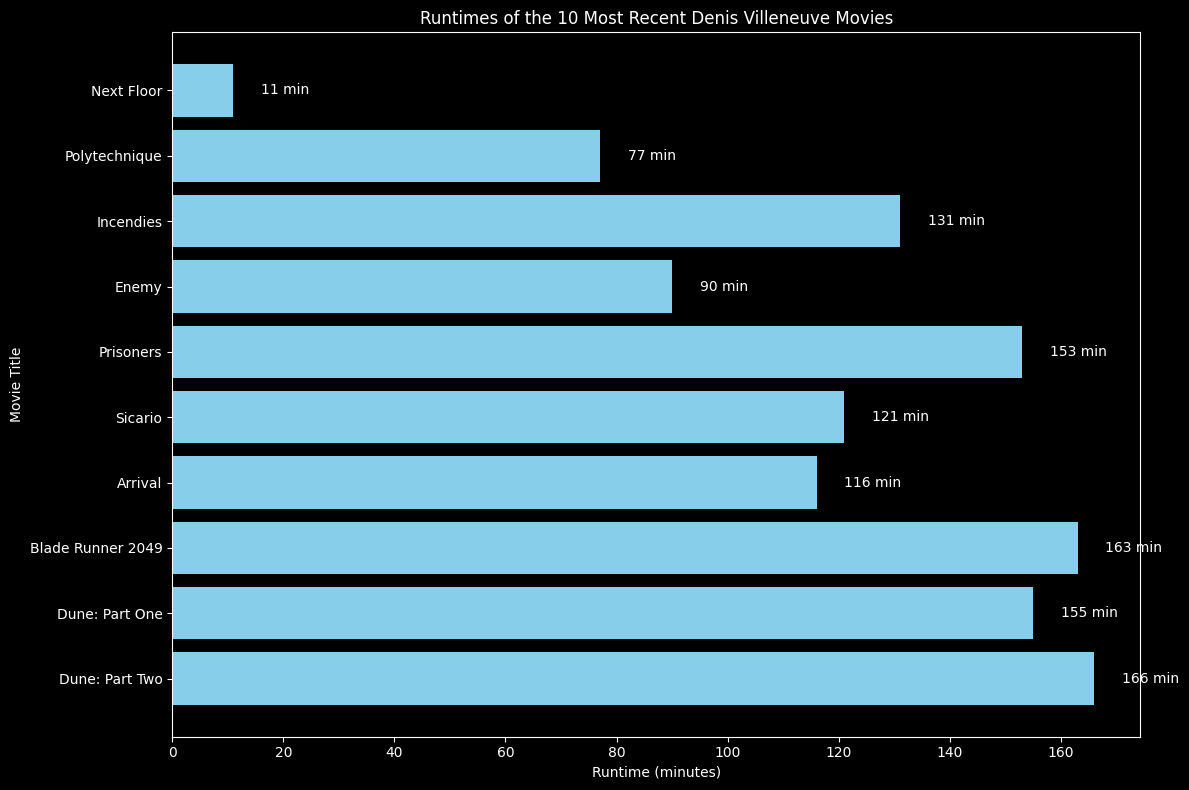

In [51]:
import re

matchFound = re.search(r"python\n(.*?)```", response.text, re.DOTALL)
print(matchFound.group(1))
if matchFound:
  code = matchFound.group(1)
  exec(code)

One feature of using a chat conversation to do this is that you can now ask the model to make changes.

In [52]:
response = movie_chat.send_message('Looks great! Can you give the chart a dark theme instead?')

show_parts(response)

Okay, here's the Python code updated to use a dark theme for the chart.

Matplotlib has a few built-in dark themes, and `dark_background` is a common one. I've added `plt.style.use('dark_background')` at the beginning of the plotting section. This will change the background of the plot to dark gray and adjust the text and bar colors for better visibility.



```python
import matplotlib.pyplot as plt

# Data for the 10 most recent Denis Villeneuve movies
# Movie Title, Release Year, Runtime (minutes)
movies_data = [
    ("Dune: Part Two", 2024, 166),
    ("Dune: Part One", 2021, 155), # [6]
    ("Blade Runner 2049", 2017, 163), # [4]
    ("Arrival", 2016, 116), # [4]
    ("Sicario", 2015, 121), # [4]
    ("Enemy", 2013, 90),
    ("Prisoners", 2013, 153), # [4]
    ("Incendies", 2010, 131),
    ("Polytechnique", 2009, 77),
    ("Next Floor", 2008, 11)
]

# Sort movies by release year for chronological plotting (already mostly sorted)
movies_data.sort(key=lambda x: x[1])

# Extracting data for plotting
titles = [movie[0] for movie in movies_data]
runtimes = [movie[2] for movie in movies_data]
release_years = [movie[1] for movie in movies_data]

# Apply a dark theme
plt.style.use('dark_background') # [3]

# Create the plot
plt.figure(figsize=(12, 8))
bars = plt.barh(titles, runtimes, color='deepskyblue') # Changed color for better contrast on dark background

# Add runtime labels to each bar
for bar in bars:
    plt.text(bar.get_width() + 5,  # Position text slightly to the right of the bar
             bar.get_y() + bar.get_height()/2,
             f'{bar.get_width()} min',
             va='center',
             color='white') # Ensure text color is visible on dark background

# Add titles and labels
plt.xlabel("Runtime (minutes)", color='white')
plt.ylabel("Movie Title", color='white')
plt.title("Runtimes of the 10 Most Recent Denis Villeneuve Movies", color='white')
plt.xticks(color='white')
plt.yticks(color='white')
plt.gca().invert_yaxis() # To display the most recent movie at the top
plt.tight_layout()

# Show the plot
plt.show()
```



Key changes for the dark theme:
*   `plt.style.use('dark_background')`: This line is added to apply Matplotlib's built-in dark background style.
*   `color='deepskyblue'`: The bar color has been changed to `deepskyblue` for better visibility against a dark background.
*   `color='white'`: The color of the text for labels, title, and ticks has been explicitly set to white to ensure they are readable.

This will give you a chart with a dark background, light blue bars, and white text, which is generally a more visually appealing "dark mode" look.

Again, always be sure to review code generated by the model before running it.

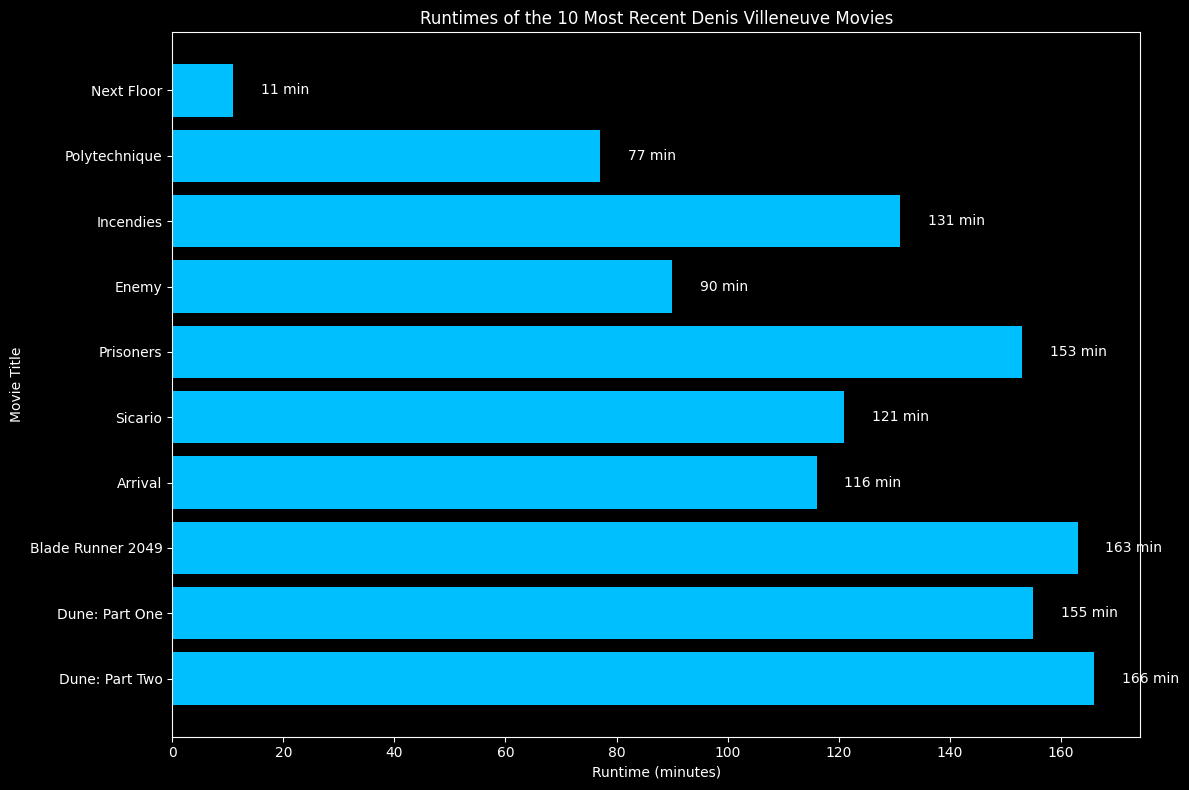

In [53]:
import re

matchFound = re.search(r"python\n(.*?)```", response.text, re.DOTALL)

if matchFound:
  code = matchFound.group(1)
  exec(code)

## Use search in the Multimodal Live API

The Search tool can be used in a live streaming context to have the model formulate grounded responses during the conversation.

In [57]:
# Live API only works with v1alpha API and with the gemini-2.0-flash-exp model at the moment

client = genai.Client(http_options={'api_version': 'v1alpha'})

LIVE_MODEL_ID = "gemini-2.0-flash-exp"

### Define some helpers

To use the bi-directional streaming API in Colab, you will buffer the audio stream. Define a `play_response` helper function to do the buffering, and once the audio for the current turn has completed, display an IPython audio widget.

As each of the following examples only use a single prompt, also define a `run` helper to wrap the setup and prompt execution steps into a single function call. This helper takes a `config` argument that will be added to the `generation_config`, so that you can toggle the Search tool between examples.

In [58]:
# @title Helper functions for the Live API (run this cell)

import asyncio
import io
import json
import re
import time
import wave

import numpy as np
from IPython.display import Audio, display


DEFAULT_OUTPUT_RATE = 24000
BASE_MODEL_CONFIG = {
    # Here you can change the model's output mode between either audio or text.
    # While this code expects an audio stream, text should work, but the stream
    # may interleave with the `Buffering....` text.
    'response_modalities': ['AUDIO']
}

async def play_response(stream):
  """Buffer audio output and display a widget. Returns the streamed responses."""
  turn_buf = io.BytesIO()
  sample_rate = DEFAULT_OUTPUT_RATE

  all_responses = []

  print('Buffering', end='')
  async for msg in stream.receive():
    all_responses.append(msg)

    if text:=msg.text:
      print(text)
    if audio_data := msg.data:
      turn_buf.write(audio_data)
      if m := re.search(
          'rate=(?P<rate>\d+)',
          msg.server_content.model_turn.parts[0].inline_data.mime_type
      ):
            sample_rate = int(m.group('rate'))

    elif tool_call := msg.tool_call:
      # Handle tool-call requests. Here is where you would implement
      # custom tool code, but for this example, all tools respond 'ok'.
      for fc in tool_call.function_calls:
        print('Tool call', end='')
        tool_response = genai.types.LiveClientToolResponse(
            function_responses=[genai.types.FunctionResponse(
                name=fc.name,
                id=fc.id,
                response={'result': 'ok'},
            )]
        )
        await stream.send(input=tool_response)

    print('.', end='')

  print()

  # Play the audio
  if turn_buf.tell():
    audio = np.frombuffer(turn_buf.getvalue(), dtype=np.int16)
    display(Audio(audio, autoplay=True, rate=sample_rate))
  else:
    print('No audio :(')
    print(f'  {len(all_responses)=}')

  return all_responses


async def run(query, config=None):
  # Add any tools or other generation config.
  config = BASE_MODEL_CONFIG | (config or {})

  # Establish a live session. While this context manager is active, the
  # conversation will continue.
  async with client.aio.live.connect(model=LIVE_MODEL_ID, config=config) as strm:

    # Send the prompt.
    await strm.send(input=query, end_of_turn=True)
    # Handle the model response.
    responses = await play_response(strm)

    return responses

### Stream with the Search tool

First, execute a query _without_ the Search tool to observe the model's response to a time-sensitive query.

Note that the Multimodal Live API is a 2-way streaming API, but to simplify running in a notebook, each audio response is buffered and played once it has been fully streamed, so you will need to wait a few seconds before the response starts to play.

In [66]:
await run('Who won the skateboarding gold medals in the 2024 olympics?');

<ipython-input-58-8d15eaa56993>:81: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await strm.send(input=query, end_of_turn=True)


Buffering

.......

.......

.......

.....

.......

.......

....

.......

.......

......


Now re-run with the Search tool enabled.

In [65]:
responses = await run('Who won the skateboarding gold medals in the 2024 olympics?', {'tools': [search_tool]})

<ipython-input-58-8d15eaa56993>:81: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await strm.send(input=query, end_of_turn=True)


Buffering

.

.

.......

.......

....

.......

........

.......

......

.......

.......

.....

.......

.....


If you wish to see the full output that was returned, you can enable `show_output` here and run this cell. It includes the complete audio binary data, so it is off by default.

In [61]:
show_output = False

if show_output:
  for msg in responses:
    print(msg.model_dump(exclude_none=True))

### Search with custom tools

In the Multimodal Live API, the Search tool can be used in conjunction with other tools, including function calls that you provide to the model.

In this example, you define a function `set_climate` that takes 2 parameters, `mode` (`hot`, `cold`, etc) and `strength` (0-10), and ask the model to set the climate control based on the live weather in the location you specify.

In [67]:
set_climate_tool = {'function_declarations': [{
    'name': 'set_climate',
    'description': 'Switches the local climate control equipment to the specified parameters.',
    'parameters': {
      'type': 'OBJECT',
      'properties': {
        # Define the "mode" argument.
        'mode': {
            'type': 'STRING',
            'enum': [
              # Define the possible values for "mode".
              "hot",
              "cold",
              "fan",
              "off",
            ],
            'description': 'Mode for the climate unit - whether to heat, cool or just blow air.',
        },
        # Define the "strength" argument.
        'strength': {
            'type': 'INTEGER',
            'description': 'Intensity of the climate to apply, 0-10 (0 is off, 10 is MAX).',
        },
      },
    },
  },
]}

search_tool = {'google_search': {}}

tools = {'tools': [search_tool, set_climate_tool]}

responses = await run("Look up the weather in Paris using search and set my climate control appropriately.", tools)

<ipython-input-58-8d15eaa56993>:81: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await strm.send(input=query, end_of_turn=True)


Buffering

.

.

<ipython-input-58-8d15eaa56993>:55: DeprecationWarning: The `session.send` method is deprecated and will be removed in a future version (not before Q3 2025).
Please use one of the more specific methods: `send_client_content`, `send_realtime_input`, or `send_tool_response` instead.
  await stream.send(input=tool_response)


....Tool call....

.......

.......

.......

.......

......

.......

.....

.......

......

..........

.....

.......

....

.....


Now inspect the `tool_call` response(s) you received during the conversation.

In [63]:
for r in responses:
  if tool := r.tool_call:
    for fn in tool.function_calls:
      args = ', '.join(f'{k}={v}' for k, v in fn.args.items())
      print(f'{fn.name}({args})  # id={fn.id}')

## Next steps

<a name="next_steps"></a>

* For more demos showcasing multi-tool use in the Multimodal Live API, check out the [Plotting and Mapping cookbook](../examples/LiveAPI_plotting_and_mapping.ipynb).
* To get started with the Live API with the Python SDK, check out the [starter guide](./Get_started_LiveAPI.ipynb).
* To learn more about tool use in the Live API, check out the [Live API Tool Use cookbook](./Get_started_LiveAPI_tools.ipynb).

Also check the other Gemini advanced capabilities (like [spatial understanding](../quickstarts/Spatial_understanding.ipynb)) that you can find in the [Gemini Cookbook](https://github.com/google-gemini/cookbook/tree/main/gemini-2/).